In [2]:
import numpy as np
from scipy.stats.mstats import mode
from copy import deepcopy
import pandas as pd
import time
%matplotlib inline
from helper import *

In [3]:
df_train = load_train_data()

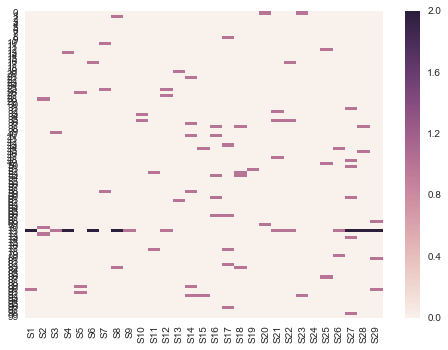

In [5]:
import seaborn as sns
df = df_train[['S'+str(i) for i in xrange(1, 30)]][:100]

_ = sns.heatmap(df)

In [74]:
# Nearest neighbors model
adjacency_list = {
    1: [2, 4, 35],
    2: [1, 34, 35, 36, 41],
    3: [4, 8],
    4: [1, 3],
    5: [7, 45],
    6: [8, 12],
    7: [5, 55],
    8: [3, 6],
    9: [12, 44],
    10: [11, 55],
    11: [10, 13],
    12: [6, 9],
    13: [11, 39],
    14: [16, 54],
    15: [14, 16],
    16: [14, 15, 17],
    17: [16, 56],
    18: [19, 56],
    19: [18, 20],
    20: [19, 21],
    21: [20, 22, 23],
    22: [21, 23, 43],
    23: [21, 24],
    24: [23, 25],
    25: [24, 26],
    26: [25, 27],
    27: [26, 28, 29],
    28: [27, 47],
    29: [27, 30],
    30: [29, 31],
    31: [30, 32],
    32: [31, 33],
    33: [32, 34, 35],
    34: [2, 33, 35, 36, 41],
    35: [1, 2, 34, 36, 41],
    36: [2, 34, 35, 41],
    37: [36, 38],
    38: [37, 40],
    39: [13, 43],
    40: [38],
    41: [2, 36, 42],
    42: [41, 46],
    43: [22, 39],
    44: [9, 45],
    45: [5, 44],
    46: [42],
    47: [28, 48],
    48: [47, 49],
    49: [48, 50],
    50: [49, 51],
    51: [50, 52, 53],
    52: [50, 51, 53],
    53: [51, 52, 54],
    54: [53, 14],
    55: [7, 10],
    56: [17, 18]
}

In [75]:

threshold = 12 # will produce the same like above

threshold = 20 # a bigger list

def compute_adjlist(threshold):
    # computing the adjacency list based on distance
    for key in xrange(56):
        node = key + 1
        adjacency_list[node] = []
        # go through all other nodes, if distance is below threshold, fine!
        for other_key in xrange(56):
            if other_key == key:
                continue

            a = np.array([df_sensors.loc[key].X, df_sensors.loc[key].Y])
            b = np.array([df_sensors.loc[other_key].X, df_sensors.loc[other_key].Y])
            dist = np.linalg.norm(a - b, ord=1)

            if dist < threshold:
                adjacency_list[node].append(other_key + 1)
                
    return adjacency_list
    
adjacency_list = compute_adjlist(20.) # best model
print adjacency_list

{1: [2, 3, 4, 35, 41], 2: [1, 4, 34, 35, 36, 41, 42], 3: [1, 4, 6, 8], 4: [1, 2, 3, 8, 35], 5: [7, 44, 45, 55], 6: [3, 8, 9, 12], 7: [5, 10, 45, 55], 8: [3, 4, 6, 12], 9: [6, 12, 44, 45], 10: [7, 11, 13, 55], 11: [10, 13, 39, 55], 12: [6, 8, 9, 44], 13: [10, 11, 39, 43], 14: [15, 16, 17, 53, 54], 15: [14, 16, 17], 16: [14, 15, 17, 54, 56], 17: [14, 15, 16, 18, 56], 18: [17, 19, 20, 56], 19: [18, 20, 21, 56], 20: [18, 19, 21, 22, 23], 21: [19, 20, 22, 23, 24, 43], 22: [20, 21, 23, 39, 43], 23: [20, 21, 22, 24, 25], 24: [21, 23, 25, 26], 25: [23, 24, 26, 27], 26: [24, 25, 27, 28, 29], 27: [25, 26, 28, 29, 30, 47], 28: [26, 27, 29, 47, 48], 29: [26, 27, 28, 30, 31], 30: [27, 29, 31, 32], 31: [29, 30, 32], 32: [30, 31, 33], 33: [32, 34, 35], 34: [2, 33, 35, 36], 35: [1, 2, 4, 33, 34, 36], 36: [2, 34, 35, 37, 38, 41, 42], 37: [36, 38, 40, 41], 38: [36, 37, 40], 39: [11, 13, 22, 43], 40: [37, 38], 41: [1, 2, 36, 37, 42, 46], 42: [2, 36, 41, 46], 43: [13, 21, 22, 39], 44: [5, 9, 12, 45], 45: 

In [76]:
# compute weights based on distance
def compute_invdist_weights(adjacency_list):
    df_sensors = pd.read_csv('data/sensor-coordinates.txt')
    df_sensors.columns = ['SID', 'X', 'Y']

    weight_list = {}
    for key in adjacency_list.keys():
        weight_list[key] = []
        b = np.array([df_sensors.loc[key - 1].X, df_sensors.loc[key - 1].Y])
        for el in adjacency_list[key]:
            # manhattan distance
            a = np.array([df_sensors.loc[el - 1].X, df_sensors.loc[el - 1].Y])
            dist = np.linalg.norm(a - b, ord=1)

            # inverse distance weighting
            weight_list[key].append(1.0 / dist)

        # scale it accordingly
        weight_list[key] = np.array(weight_list[key])
        weight_list[key] = weight_list[key] / np.sum(weight_list[key])
    return weight_list

In [77]:
weight_list = compute_invdist_weights(adjacency_list)
print weight_list

{1: array([ 0.26045422,  0.14217225,  0.26045422,  0.22032459,  0.11659471]), 2: array([ 0.21620409,  0.12975295,  0.11816935,  0.14613954,  0.113855  ,
        0.17522827,  0.10065081]), 3: array([ 0.15261928,  0.3360642 ,  0.17572633,  0.3355902 ]), 4: array([ 0.25900368,  0.15543874,  0.31131657,  0.15554843,  0.11869258]), 5: array([ 0.33266544,  0.17427463,  0.33309303,  0.1599669 ]), 6: array([ 0.16795918,  0.35258407,  0.15869974,  0.32075702]), 7: array([ 0.3439424 ,  0.16538959,  0.17208165,  0.31858636]), 8: array([ 0.32018326,  0.16020461,  0.35195339,  0.16765874]), 9: array([ 0.16636121,  0.32927571,  0.33624205,  0.16812103]), 10: array([ 0.15841786,  0.32986752,  0.18227055,  0.32944407]), 11: array([ 0.30222718,  0.37322658,  0.1735297 ,  0.15101654]), 12: array([ 0.33359112,  0.17467955,  0.32667971,  0.16504962]), 13: array([ 0.16233161,  0.36279826,  0.31525917,  0.15961096]), 14: array([ 0.14732678,  0.25878421,  0.13450389,  0.15205604,  0.30732907]), 15: array([ 0

In [66]:
# Several possibilities to average the result among the neighbors:
#    - cumulative sum of neighbors (v1)
#    - average (truncated) (v2)
#    - average (raw) (v3) 
#    - average (rounded) (v4)
#    - average with inv distance weight, larger adj list (raw) (v5 Leo) ** best
def fill_neighbors(row, col_name, adjacency_list):
    if row[col_name] == -1:
        new_value = 0.
        count = 0
        col_ind = int(col_name[1:])
        pos = 0
        for n in adjacency_list[col_ind]:
            if row[n] != -1:
                new_value += row[n] * weight_list[col_ind][pos]
                count += weight_list[col_ind][pos] # + 1
            pos = pos + 1
            
        # if some neighbours were working return their average (raw)
        if count:
            return new_value / (1. * count)#round(new_value / (1. * count))
        
        # if no neighbours were working, return 0 (most frequent value)
        return new_value
    else:
        return row[col_name]



In [67]:
col_names = ['S'+str(i) for i in xrange(1, 57)]
df_train_neighbors_avg = df_train.copy()

In [68]:
for col_name in col_names:
    start = time.time()
    df_train_neighbors_avg[col_name] = df_train.apply(lambda row: fill_neighbors(row, col_name, adjacency_list),axis=1)
    total_time = time.time() - start
    print 'Col {} computed in {}'.format(col_name, total_time)

Col S1 computed in 0.942090034485
Col S2 computed in 0.906429052353
Col S3 computed in 0.806999921799
Col S4 computed in 1.12859916687
Col S5 computed in 0.834068059921
Col S6 computed in 1.86708593369
Col S7 computed in 0.773229837418
Col S8 computed in 0.880380868912
Col S9 computed in 2.2086930275
Col S10 computed in 0.828159093857
Col S11 computed in 0.779759168625
Col S12 computed in 1.01583504677
Col S13 computed in 2.72057294846
Col S14 computed in 3.12556099892
Col S15 computed in 0.830410957336
Col S16 computed in 0.760320901871
Col S17 computed in 2.3074657917
Col S18 computed in 0.844022989273
Col S19 computed in 0.974555015564
Col S20 computed in 3.06198501587
Col S21 computed in 0.90279507637
Col S22 computed in 1.02028298378
Col S23 computed in 3.06308603287
Col S24 computed in 0.887583971024
Col S25 computed in 1.01239609718
Col S26 computed in 2.49779891968
Col S27 computed in 0.798434972763
Col S28 computed in 2.46609997749
Col S29 computed in 3.31261396408
Col S30 com

In [69]:
# Checking that all the values are filled (i.e no -1 left)
cum_sum = 0
for col in col_names:
    cum_sum += len(df_train_neighbors_avg[df_train_neighbors_avg[col] == -1])
print cum_sum

0


In [70]:
create_submission_file(df_train_neighbors_avg, 'nearest_v5Leo.csv')